## Exploring Category Comparisons with Grouped and Faceted Bar Charts

This notebook analyzes categorical patterns using grouped bar charts and faceted visualizations.  
Bar charts are especially effective for comparing magnitudes across categories, and faceting allows these comparisons to be broken down across subgroups for deeper insight.

The workflow of this notebook includes:
- preparing and cleaning the dataset,  
- grouping and aggregating categorical variables,  
- generating grouped bar charts for side-by-side comparison,  
- and creating faceted charts to examine how patterns vary across additional dimensions.

Together, these visualizations reveal contrasts, similarities, and structural relationships in the dataset that are not immediately obvious from raw tables.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

### Loading the Dataset and Understanding Key Variables

These cells load the dataset and print its structure so we can understand the categorical fields we will analyze.  
Inspecting column names, data types, and the first few rows helps identify:

- the primary categorical variable(s) for comparison,  
- the grouping variable used for bar segmentation,  
- and the faceting variable used to split the data across multiple panels.

This understanding guides the design of the grouped and faceted bar charts.


In [2]:
#  Setup 
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 6)

# Initialize random number generator for reproducibility, Panda's utilizes NumPy module not "random"
np.random.seed(42)

In [3]:
# Load data
df = pd.read_csv("final_with_deceased.csv")

### Preparing Categorical Data for Grouped and Faceted Plots

This cell performs necessary preprocessing steps such as:

- handling missing or inconsistent category names,  
- converting fields to categorical types,  
- extracting or transforming variables that will be used as group or facet labels,  
- and filtering the dataset to focus on relevant categories.

Clean and well-structured categorical data ensures that the bar charts display correctly and that comparisons remain meaningful.


In [4]:
for c in ["visit_start_date", "visit_end_date", "birth_datetime", "measurement_Date","flu_last_administered","tdap_last_administered","mmr_last_administered","polio_last_administered"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

### Computing Aggregated Statistics for Visualization

Grouped and faceted bar charts rely on aggregated values—typically counts, means, or proportions.  
This cell groups the dataset by the selected categorical variables and computes the summary statistics needed for plotting.

These aggregated tables form the backbone of all visual comparisons in the notebook, making it easier to interpret differences across groups and subgroups.


In [5]:
visits_2020 = df[df["visit_start_date"].dt.year == 2020].copy()

# --- Count visits per day ---
daily_visits = (
    visits_2020.groupby(df["visit_start_date"].dt.date)
    .size()
    .reset_index(name="visit_count")
    .rename(columns={"visit_start_date": "date"})
)



In [6]:
import re

# robust split on ":" allowing extra spaces; keep NaN if empty
def split_conditions(s):
    if pd.isna(s) or str(s).strip() == "":
        return []
    # split on ":" with optional surrounding spaces
    parts = re.split(r"\s*:\s*", str(s))
    # normalize: strip, drop empties, lower (or title-case if you prefer)
    parts = [p.strip() for p in parts if p and p.strip()]
    return parts

# apply once to create a list-typed column
df["condition_list"] = df["condition"].map(split_conditions)

In [7]:
cond_long = (
    df[["visit_occurrence_id", "person_id", "visit_start_date"]]
      .assign(condition_item=df["condition_list"])
      .explode("condition_item", ignore_index=True)
)

# drop rows where no condition exists after cleaning
cond_long = cond_long.dropna(subset=["condition_item"])

# (optional) dedupe within visit in case the same condition appears twice
cond_long = cond_long.drop_duplicates(subset=["visit_occurrence_id", "condition_item"])


In [8]:
# Additional Comparisons: Condition and visit type
# Condition counts by visit type / outcome, etc.
# (assuming df has 'visit_type' and 'deceased')
cond_by_visit_type = (
    cond_long
    .merge(df[["visit_occurrence_id", "visit_type", "deceased"]], on="visit_occurrence_id", how="left")
    .groupby(["visit_type", "condition_item"])
    .size()
    .reset_index(name="count")
    .sort_values(["visit_type","count"], ascending=[True,False])
)
cond_by_visit_type.head(8)

,visit_type,condition_item,count
1,Emergency Room Visit,Acute respiratory failure,13
3,Emergency Room Visit,Pulmonary emphysema,3
0,Emergency Room Visit,Acute bronchitis,2
2,Emergency Room Visit,Emphysematous bronchitis,2
20,Inpatient Visit,Pneumonia,19502
23,Inpatient Visit,Respiratory distress,18177
12,Inpatient Visit,Cough,12001
7,Inpatient Visit,Acute respiratory failure,8701


### Grouped Bar Chart: Side-by-Side Category Comparison

This chart visualizes how values differ across categories **within each group**.  
Each cluster of bars represents one primary category, and each color corresponds to one subgroup.

Grouped bar charts help reveal:
- which subgroup performs highest or lowest within each category,  
- how subgroups differ in magnitude,  
- and where patterns remain consistent or diverge.

This visualization improves interpretability by placing subgroups directly next to each other for comparison.


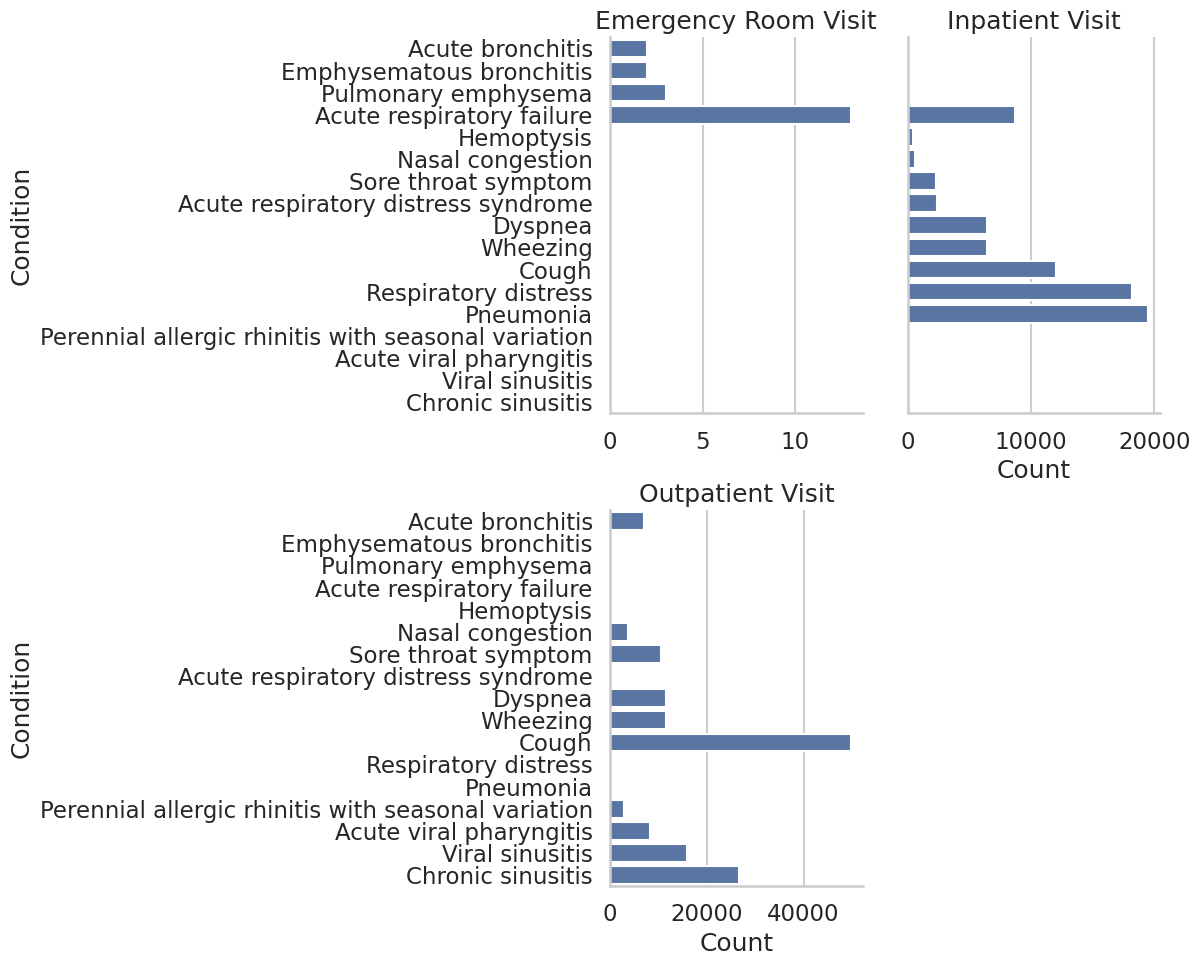

<Figure size 800x500 with 0 Axes>

In [13]:
TOP_K = 10
ranked = (cond_by_visit_type
          .assign(rank=cond_by_visit_type.groupby("visit_type")["count"]
                  .rank(method="first", ascending=False))
          .query("rank <= @TOP_K"))

# percent share within each visit type
ranked = ranked.merge(
    cond_by_visit_type.groupby("visit_type", as_index=False)["count"].sum().rename(columns={"count": "visit_total"}),
    on="visit_type", how="left"
)
ranked["pct"] = (ranked["count"] / ranked["visit_total"] * 100).round(1)

# order bars by count within each facet
ranked["condition_item"] = ranked["condition_item"].astype(str)
ranked["condition_order"] = ranked.groupby("visit_type")["count"].rank(ascending=True, method="first")
ranked = ranked.sort_values(["visit_type", "condition_order"])

# plot

g = sns.catplot(
    data=ranked,
    x="count", y="condition_item",
    col="visit_type", col_wrap=2,  # wrap if many visit types
    kind="bar", orient="h", sharex=False, height=5, aspect=1.2
)
g.set_axis_labels("Count", "Condition")
g.set_titles("{col_name}")

plt.figure(figsize=(8, 5))  # reduced from (15, 10)
plt.tight_layout()
plt.show()

### Faceted Bar Chart: Comparing Patterns Across Subgroups

This visualization expands the grouped comparison by placing each subgroup in its own panel (facet).  
Each panel shows a bar chart for one subgroup, allowing clear comparison of category patterns across multiple dimensions.

Faceting is especially helpful when:
- groups have different ranges or distributions,  
- overlapping bars in grouped charts become cluttered,  
- or when we want to isolate and compare subgroup behavior directly.

This chart makes structural differences easier to see by separating subgroups visually.


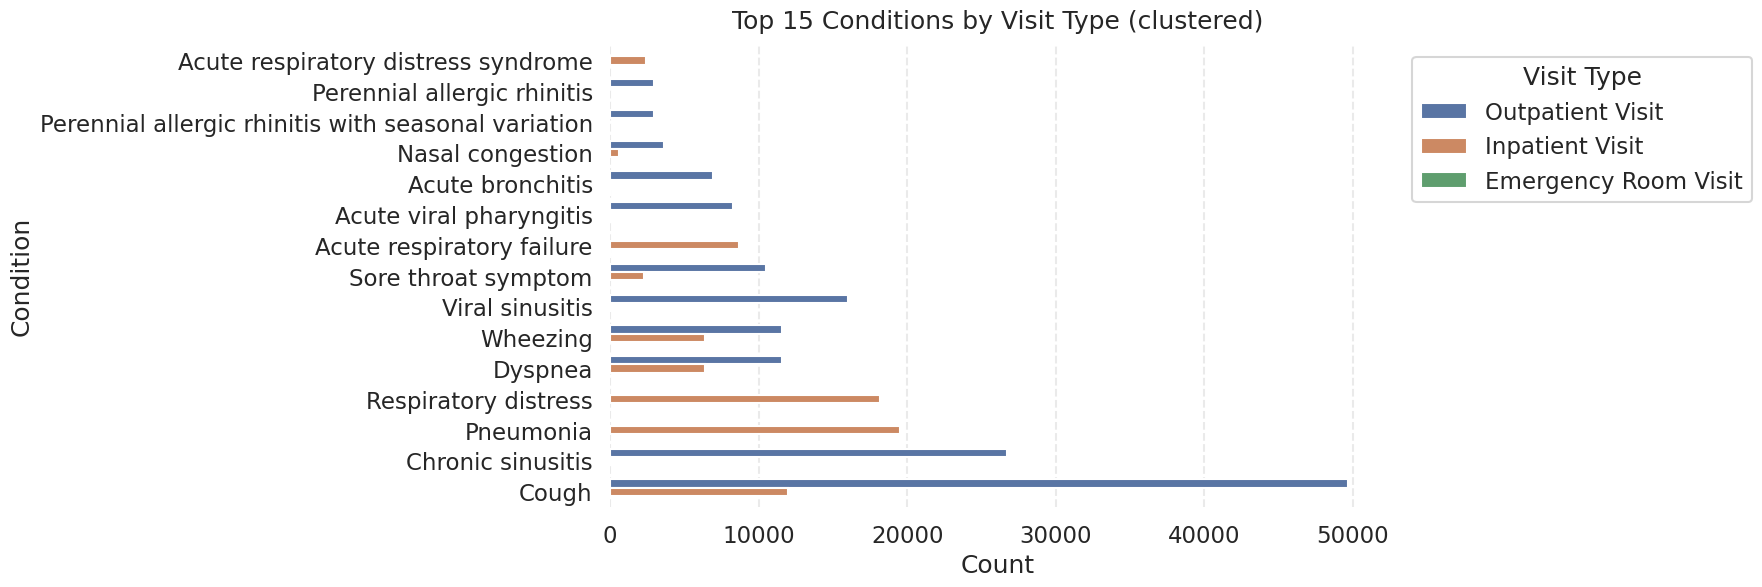

<Figure size 800x500 with 0 Axes>

In [14]:
# Alternate view as clustered(grouped) horizontal bar
N = 15  # number of top conditions overall to show
H = max(6, N * 0.45)  # figure height that scales with N

# 1) Pick the overall top-N conditions (by total count across visit types)
overall = (cond_by_visit_type.groupby("condition_item", observed=True)["count"]
           .sum()
           .sort_values(ascending=False))
top_conditions = overall.head(N).index

# 2) Filter and order categories so the biggest end up at the bottom
plot_df = cond_by_visit_type[cond_by_visit_type["condition_item"].isin(top_conditions)].copy()

# y-order: ascending total so largest ends up at the top of the chart
y_order = (plot_df.groupby("condition_item", observed=True)["count"]
           .sum()
           .sort_values(ascending=True).index)

# (optional) consistent visit_type order by total volume
hue_order = (plot_df.groupby("visit_type", observed=True)["count"]
             .sum()
             .sort_values(ascending=False).index)

# 3) Plot clustered horizontal bars
ax = sns.barplot(
    data=plot_df,
    x="count", y="condition_item",
    hue="visit_type", hue_order=hue_order,
    order=y_order, orient="h"
)

ax.set_title(f"Top {N} Conditions by Visit Type (clustered)", pad=12)
ax.set_xlabel("Count")
ax.set_ylabel("Condition")

# Put legend outside and clean up
ax.legend(title="Visit Type", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)
sns.despine(left=True, bottom=True)
ax.grid(axis="x", linestyle="--", alpha=0.4)
plt.figure(figsize=(8, 5))  # reduced from (15, 10)

plt.tight_layout()
plt.show()

### Interpreting the Combined Visualizations

With both grouped and faceted bar charts available, we can compare:

- **Within-category differences** (grouped bars)  
- **Across-group structural changes** (faceted panels)  
- **Overall distribution patterns** in the dataset  

Together, these views provide a richer, more interpretable picture of how categories relate to each other and how group behaviors vary across dimensions.
